In [5]:
import numpy as np
from scipy.stats import crystalball
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

# Full spectrum

In [6]:
class AlphaDecay:
    """
    Represents an alpha-decay isotope with time distribution and optional energy.
    """
    def __init__(self, name, energy_keV, half_life_s, beta=None, m=None, scale=None,
                 branching_ratio=1.0, next_decay=None):
        self.name = name
        self.energy_keV = energy_keV
        self.half_life_s = half_life_s
        self.branching_ratio = branching_ratio
        self.next_decay = next_decay
        # Only create Crystal Ball if energy provided
        if energy_keV is not None:
            self.cb_dist = crystalball(beta=beta, m=m, loc=energy_keV, scale=scale)
        else:
            self.cb_dist = None



In [7]:
def simulate_chain(start_decay, n_chains, observation_window_s=None, seed=None):
    """
    Simulate n_chains decay chains from `start_decay`.
    Returns list of events with keys ['chain','mode','time_s','energy_keV'].
    If observation_window_s is set, only events with time_s <= window are recorded.
    """
    rng = np.random.default_rng(seed)
    events = []
    for cid in range(n_chains):
        t = 0.0
        decay = start_decay
        while decay:
            # draw decay time
            dt = rng.exponential(scale=decay.half_life_s / np.log(2))
            t += dt
            # stop if beyond observation window
            if observation_window_s is not None and t > observation_window_s:
                break
            # branching decision
            if rng.random() <= decay.branching_ratio:
                # sample energy if available
                if decay.cb_dist is not None:
                    E = decay.cb_dist.ppf(rng.uniform(1e-9, 1 - 1e-9))
                    events.append({'chain': cid,
                                   'mode': decay.name,
                                   'time_s': t,
                                   'energy_keV': E})
            # move to next decay in chain
            decay = decay.next_decay
    return events


def plot_energy_spectrum(events, modes=None, bins=1000, xmin=None, xmax=None):
    """
    Overlay energy histograms for specified decay modes.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    labels = sorted({e['mode'] for e in events})
    for label, color in zip(labels, plt.cm.tab10.colors):
        if modes and label not in modes:
            continue
        energies = [e['energy_keV'] for e in events if e['mode'] == label]
        ax.hist(energies, bins=bins, range=(xmin, xmax), alpha=0.5,
                label=label, color=color)
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Counts")
    ax.legend()
    ax.set_title("Simulated Alpha Energy Spectrum")
    plt.tight_layout()
    return fig, ax


def plot_time_differences(events, mode_pair=None, bins=100, tmax=None):
    """
    Histogram of time differences between successive decays in each chain.
    If mode_pair=(m1,m2), only include dt between those two modes.
    """
    from collections import defaultdict
    chains = defaultdict(list)
    for e in events:
        chains[e['chain']].append(e)
    dt_list = []
    for evs in chains.values():
        evs_sorted = sorted(evs, key=lambda x: x['time_s'])
        for i in range(len(evs_sorted)-1):
            m1 = evs_sorted[i]['mode']
            m2 = evs_sorted[i+1]['mode']
            dt = evs_sorted[i+1]['time_s'] - evs_sorted[i]['time_s']
            if mode_pair is None or (m1, m2) == mode_pair:
                dt_list.append(dt)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(dt_list, bins=bins, range=(0, tmax), alpha=0.7)
    ax.set_xlabel("Time difference (s)")
    ax.set_ylabel("Counts")
    title = "Time differences"
    if mode_pair:
        title += f" from {mode_pair[0]} to {mode_pair[1]}"
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

In [8]:
beta, m, scale = 0.98, 1.97, 3.43

In [9]:
# Build chain including Pb-212 (no alpha), Bi-212, Po-212
po212 = AlphaDecay("Po212", 8954, half_life_s=0.299e-6,
                    beta=beta, m=m, scale=scale)
bi212 = AlphaDecay("Bi212", 6207, half_life_s=60.55*60,
                    beta=beta, m=m, scale=scale,
                    branching_ratio=0.359, next_decay=po212)
pb212 = AlphaDecay("Pb212", None, half_life_s=10.64*3600,
                    branching_ratio=1.0, next_decay=bi212)
po216 = AlphaDecay("Po216", 6906, half_life_s=0.145,
                    beta=beta, m=m, scale=scale,
                    next_decay=pb212)
rn220 = AlphaDecay("Rn220", 6405, half_life_s=55.6,
                    beta=beta, m=m, scale=scale,
                    next_decay=po216)
ra224b = AlphaDecay("Ra224", 5685, half_life_s=3.66*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=rn220)

ra224b = AlphaDecay("Ra224_B", 5448, half_life_s=3.66*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=rn220)
ra224 = AlphaDecay("Ra224", 5685, half_life_s=3.66*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=rn220)
th228b = AlphaDecay("Th228_B", 5340, half_life_s=1.9116*365.25*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=ra224)
th228 = AlphaDecay("Th228", 5423, half_life_s=1.9116*365.25*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=ra224)


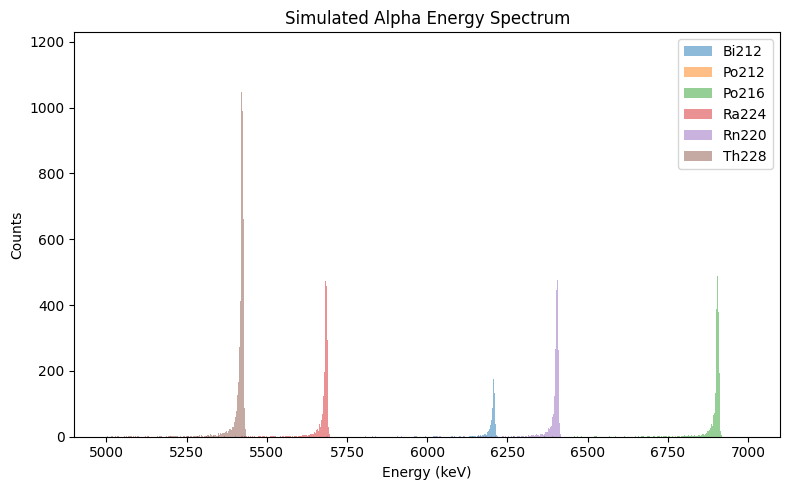

In [10]:
observation_window_s = 7 * 24 * 3600  # 7 days in seconds
# Simulate with a 2-day observation window
events = simulate_chain(th228, n_chains=1_000_000,
                        observation_window_s=observation_window_s, seed=2025)
# Plot energy and time differences
plot_energy_spectrum(events, xmin=5000, xmax=7000)
plt.show()
